# Генеративно-состязательные сети (Generative Adversarial Networks)

В задании предлагается реализовать GAN, обучить её на MNIST, оценить правдоподобие и сделать выводы.

Необходимая теория приведена ниже.

Актуальная версия доступна по адресу https://github.com/nadiinchi/dl_labs/blob/master/lab_gan.ipynb

## Постановка задачи
Дана выборка независимых одинаково распределенных величин из истинного распределения $x_i \sim p_d(x)$, $i = 1, \dots, N$.

Задача - построить вероятностную модель $p_\theta(x)$ истинного распределения $p_d(x)$.

Распределение $p_\theta(x)$ должно позволять как оценить плотность вероятности для данного объекта $x$, так и сэмплировать $x \sim p_\theta(x)$.

## Вероятностная модель
$z \in \mathbb{R}^d$ - локальная латентная переменная, т. е. своя для каждого объекта $x \in \mathbb{R}^D$.

Генеративный процесс вариационного автокодировщика:
1. Сэмплируем $z \sim p(z)$.
2. $x = G_\theta(z)$.

Параметры преобразования $G_\theta(z)$ задаются нейросетью с весами $\theta$, получающей на вход вектор $z$.

Индуцированная генеративным процессом плотность вероятности объекта $x$:

$$p_\theta(x) = \mathbb{E}_{z \sim p(z)} \delta(x = G(z))$$

## Оценка логарифма правдоподобия
Для оценки логарифма правдоподобия используется метод Парзеновского окна/ядерного сглаживания (англ. Kernel Density Estimation/Parzen–Rosenblatt window method). Концептуально он заключается в том, что мы сглаживаем модельное распределение, и по этому сглаженному распределению вычисляем правдоподобие модели.

$$p_\theta(x) = \mathbb{E}_{z \sim p(z)} \delta(x = G(z)) \approx \frac{1}{Mh^D}\sum_{i=1}^M K\left(\frac{x - G_\theta(z_i)}{h}\right)$$

Здесь $K(x)$ - любое распределение, а $h$ - ширина окна. Тогда выполняется

$$\mathbb{E}_{x \sim p_d} \log p_\theta(x) \approx  \frac{1}{N}\sum_{i=1}^{N} \log \frac{1}{Mh^D}\sum_{j=1}^M K\left(\frac{x_i - G_\theta(z_j)}{h}\right)$$

В генеративно-состязательных сетях для оценки правдоподобия используется стандартное нормальное распределение $K(x) = N(x | 0, I)$. Тогда получаем

$$\mathbb{E}_{x \sim p_d} \log p_\theta(x) \approx  \frac{1}{N}\sum_{i=1}^{N} \log \frac{1}{M}\sum_{j=1}^M \prod_{k=1}^D\frac{1}{\sqrt{2 \pi} \sigma}\exp\left(-\frac{(x_{i,k} - G(z_j)_k)^2}{2\sigma^2}\right)$$

Коэффициент $\sigma$ настраивается на валидационной выборке и с его помощью считается правдоподобие тестовой выборки.

### Загрузка, нормировка и визуалиация данных

In [1]:
import math
import torch
from torch import nn
from torch import optim
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader

In [2]:
data = MNIST('mnist', download=True, train=True)
train_data = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 255)
data = MNIST('mnist', download=True, train=False)
test_data_raw = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 255)

In [3]:
digit_size = 14

In [4]:
train_data.tensors = (nn.AvgPool2d(2, 2)(train_data.tensors[0].view(-1, 28, 28)).data.view(-1, 196), )
test_data_raw.tensors = (nn.AvgPool2d(2, 2)(test_data_raw.tensors[0].view(-1, 28, 28)).data.view(-1, 196), )

In [5]:
valid_data = TensorDataset(test_data_raw.tensors[0][:5000])
test_data = TensorDataset(test_data_raw.tensors[0][5000:])

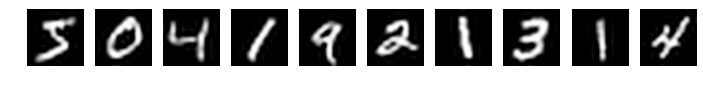

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

def show_images(x):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    x = x.view(-1, digit_size, digit_size)
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(x.data[i].numpy(), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
        plt.axis('off')

show_images(train_data[:10][0])

In [7]:
n = 15

from scipy.stats import norm
import numpy as np

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def draw_manifold(generator):
    figure = np.zeros((digit_size * n, digit_size * n))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])

            x_decoded = generator(z_sample)
            digit = x_decoded
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
    plt.axis('off')
    plt.show()

### Функции и классы, описывающие модель и процесс её обучения

In [8]:
class Reshape(nn.Module):
    def __init__(self, *args):
        """
        Запоминает размерности, в которые при проходе
        вперед будут переводиться все объекты.
        Например,
            input = torch.zeros(100, 196)
            reshape_layer = Reshape(1, 14, 14)
            reshape_layer(input)
        возвращает тензор размерности (100, 1, 14, 14).
            input = torch.zeros(100, 1, 14, 14)
            reshape_layer = Reshape(-1)
            reshape_layer(input)
        наоборот вернет тензор размерности (100, 196).
        """
        super(type(self), self).__init__()
        self.dims = args

    def forward(self, input):
        """
        Возвращает тензор с измененными размерностями объектов.
        Вход: input, FloatTensor.
        Возвращаемое значение: FloatTensor.
        """
        return input.view(input.size(0), *self.dims)

In [9]:
class GAN(nn.Module):
    def __init__(self, d):
        """
        Инициализирует веса модели.
        Вход: d, int - размерность латентного пространства.
        Вход: D, int - размерность пространства объектов.
        """
        super(type(self), self).__init__()
        self.d = d
        # Можно пробовать другие архитектуры: как более сложные
        # сверточные, так и более простые, например, полносвязные.
        # Однако желательно обучить хотя бы одну сверточную модель.
        self.discriminator = nn.Sequential(
            Reshape(1, 14, 14),
            nn.Conv2d(1, 64, 3, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 32, 3, 2, 0, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 16, 3, 1, 0, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            Reshape(-1),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        self.generator = nn.Sequential(
            Reshape(self.d, 1, 1),
            nn.ConvTranspose2d(self.d, 128, 4, 1, 0, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, 2, 1, 0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, 2, 1, 1, bias=False),
            Reshape(-1),
            nn.Sigmoid()
        )

    def generate_noise(self, num_samples):
        """
        Генерирует сэмплы из априорного распределения на z.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Tensor, матрица размера num_samples x d.
        """
        # ваш код здесь
        mu = torch.zeros(num_samples, self.d)
        sigma = torch.ones(num_samples, self.d)
        z = torch.normal(mu, sigma)
        if next(self.parameters()).is_cuda:
            z = z.cuda()
        return z

    def generate_samples(self, num_samples):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Tensor, матрица размера num_samples x D.
        """
        # ваш код здесь
        z = self.generate_noise(num_samples)
        x = self.generator(z)
        return x

    def discriminator_loss(self, batch):
        """
        Вычисляет значение функции потерь дискриминатора на данном батче.
        Возвращаемая оценка должна быть дифференцируема по параметрам модели (!).
        Вход: batch, FloatTensor - матрица объектоа размера n x D.
        Возвращаемое значение: Tensor, скаляр - значение функции потерь
        дискриминатора на данном батче.
        """
        # ваш код здесь
        batch_size, _ = batch.shape
        noise = torch.normal(torch.ones(batch.shape)*0.0, torch.ones(batch.shape)* 0.1)
        if next(self.parameters()).is_cuda:
            noise = noise.cuda()
        new_batch = batch + noise
        real = self.discriminator(new_batch)
        gen_obj = self.generate_samples(batch_size)
        noise = torch.normal(torch.ones(gen_obj.shape)*0.0, torch.ones(gen_obj.shape)* 0.1)
        if next(self.parameters()).is_cuda:
            noise = noise.cuda()
        gen_obj = gen_obj + noise
        fake = self.discriminator(gen_obj)
        ones = torch.ones(real.shape)
        zeros = torch.zeros(fake.shape)
        if next(self.parameters()).is_cuda:
            ones = ones.cuda()
            zeros = zeros.cuda()
        loss = nn.BCELoss()
        d_loss_real = loss(real, ones)
        d_loss_fake = loss(fake, zeros)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        return d_loss

    def generator_loss(self, batch_size):
        """
        Вычисляет значение функции потерь генератора на данном батче.
        Возвращаемая оценка должна быть дифференцируема по параметрам модели (!).
        Вход: batch, FloatTensor - матрица объектоа размера n x D.
        Возвращаемое значение: Tensor, скаляр - значение функции потерь
        генератора на данном батче.
        """
        # ваш код здесь
        gen_obj = self.generate_samples(batch_size)
        noise = torch.normal(torch.ones(gen_obj.shape)*0.0, torch.ones(gen_obj.shape)* 0.1)
        if next(self.parameters()).is_cuda:
            noise = noise.cuda()
        gen_obj = gen_obj + noise
        fake = self.discriminator(gen_obj)
        ones = torch.ones(fake.shape)
        if next(self.parameters()).is_cuda:
            ones = ones.cuda()
        loss = nn.BCELoss()
        return loss(fake, ones)

In [23]:
def log_mean_exp(mtx):
    """
    Возвращает логарифм среднего по каждому столбцу от экспоненты данной матрицы.
    Подсказка: не забывайте про вычислительную стабильность!
    Вход: mtx, Tensor - матрица размера n x k.
    Возвращаемое значение: Tensor, вектор длины n.
    """
    # ваш код здесь
    k = mtx.shape[-1]
    output = torch.logsumexp(mtx, dim=-1) - torch.log(torch.tensor(k, device=mtx.device).float())
    return output

In [25]:
from scipy import optimize
import math

def log_likelihood(generated_set, validation_set, test_set):
    """
    Возвращает оценку логарифма правдоподобия модели GAN методом
    Парзеновского окна со стандартным нормальным ядром.
    Подсказка: sigma должна настраиваться по валидационной выборке, а
    правдоподобие считаться по тестовой.
    Подсказка: вместо sigma можно настраивать log_sigma.
    Подсказка: для настойки sigma допустимо использовать как перебор по сетке,
    так и другие методы опимизации.
    Вход: generated_set - сэмплы из генеративной модели.
    Вход: validation_set - валидационная выборка.
    Вход: test_set - тестовая выборка.
    Возвращаемое значение: float (не Tensor!) - оценка логарифма правдоподобия.
    """
    # ваш код здесь
    gen_size, D = generated_set.shape
    val_size, _ = validation_set.shape
    test_size, _ = test_set.shape
    
    def evalu(sigma, v_set=validation_set, gen_set=generated_set, gen_size=gen_size, val_size=val_size, D=D):
        sigma = torch.tensor(sigma, device=v_set.device, dtype=v_set.dtype)
        
        diff = (v_set**2).sum(dim=-1).view(-1, 1) + (gen_set**2).sum(dim=-1).view(1, -1) 
        diff = diff - 2 *torch.mm(v_set, torch.transpose(gen_set, 0, 1))
        evaluation = log_mean_exp(-diff/(2 * sigma * sigma))
        evaluation = (evaluation +  torch.log(torch.tensor(1 / (gen_size * math.sqrt(2 * math.pi) * sigma),
                                                           device=v_set.device))).mean(dim=0)
        return evaluation
    
    result = optimize.minimize(lambda x: -1*evalu(x), 0.45, bounds=[(0.2, 0.8)])
    best_sigma = result.x
#     sigma_set = np.linspace(0.1, 2, 10)
#     best_sigma = 0.1
#     best_eval = evalu(best_sigma)
#     for sigma in sigma_set:
#         cur_eval = evalu(sigma)
#         if cur_eval > best_eval:
#             best_sigma = sigma
#             best_eval = cur_eval
    lld = evalu(best_sigma, v_set=test_set)
    return float(lld)

In [17]:
def generate_many_samples(model, num_samples, batch_size):
    size = 0
    res = []
    while size < num_samples:
        res.append(model.generate_samples(min(batch_size, num_samples - size)))
        size += batch_size
    return torch.cat(res, 0)

In [18]:
def train_model(model, num_epochs=100):
    """
    Обучает модель.
    Вход: model, Module - объект, модель.
    У этого объекта должна быть функция batch_loss от batch - FloatTensor и K - int,
    возвращающая скаляр Variable - функцию потерь на батче, которая должна быть
    оптимизирована.
    Вход: k, int - число итераций оптимизации дискриминатора на итерацию оптимизации
    генератора.
    Вход: batch_size, int.
    Вход: num_epochs, int.
    Вход: learning_rate, float.
    Возвращаемое значение: словарь с полями 'model' - обученная модель,
    'generator_losses' - список значений функции потерь генератора,
    'discriminator_losses' - список значений функции потерь дискриминатора.
    """
    if torch.cuda.is_available():
        model = model.cuda()
    model.train()

    # возможно, нужно подобрать другие параметры, чтобы модель обучилась
    batch_size = 64
    learning_rate = 2e-4

    # возможно, нужно использовать другие методы оптимизации или параметры методов оптимизации,
    # чтобы модель обучилась
    gd_generator = optim.Adam(model.generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    gd_discriminator = optim.RMSprop(model.discriminator.parameters(), lr=learning_rate)

    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    total_batches = len(dataloader)

    generator_losses = [0]
    discriminator_losses = [0]
    log_likelihoods = []

    generated_samples = generate_many_samples(model, 512, batch_size).detach()
    valid_samples = valid_data[np.random.choice(len(valid_data), 512, False)][0]
    valid_samples = valid_samples.to(next(model.parameters()).device)
    test_samples = test_data[np.random.choice(len(test_data), 512, False)][0]
    test_samples = test_samples.to(next(model.parameters()).device)
    ll = log_likelihood(generated_samples, valid_samples, test_samples)
    log_likelihoods.append(ll)
    print('Log-likelihood', ll, flush=True)

    for epoch in range(num_epochs):
        for i, (batch, ) in enumerate(dataloader):
            if torch.cuda.is_available():
                batch = batch.cuda()

            # ваш код здесь!
            # разрешается менять код этой функции для реализации
            # более сложных процедур обучения или ускорения обучения
            discriminator_loss = model.discriminator_loss(batch)
            gd_discriminator.zero_grad()
            discriminator_loss.backward()
            gd_discriminator.step()
            
            
            generator_loss = model.generator_loss(batch.shape[0])
            gd_generator.zero_grad()
            generator_loss.backward()
            gd_generator.step()

            # не забудьте корректно сохранить статистику
            discriminator_losses.append(float(discriminator_loss))
            generator_losses.append(float(generator_loss))

            if (i + 1) % 100 == 0:
                print('\rEpoch:', epoch, 'G_loss:', generator_losses[-1],
                      'D_loss:', discriminator_losses[-1],
                      'Batch', i + 1, 'of', total_batches,
                      ' ' * 10, end='', flush=True)
        print(flush=True)
        generated_samples = generate_many_samples(model, 512, batch_size).detach()
        valid_samples = valid_data[np.random.choice(len(valid_data), 512, False)][0]
        valid_samples = valid_samples.to(next(model.parameters()).device)
        test_samples = test_data[np.random.choice(len(test_data), 512, False)][0]
        test_samples = test_samples.to(next(model.parameters()).device)
        ll = log_likelihood(generated_samples, valid_samples, test_samples)
        log_likelihoods.append(ll)
        print('Log-likelihood', ll, flush=True)

    return {
        'model': model.cpu(),
        'generator_losses': generator_losses,
        'discriminator_losses': discriminator_losses,
        'log_likelihoods': log_likelihoods
    }

### Обучение модели

In [27]:
# Подсказка: обучать GANs с скрытой размерностью 2 непросто,
# для этого требуется очень аккуратно подобрать хаки/процесс обучения/
# /архитектуру модели/инициализацию.
# Если не получается сразу, стоит обучить GANs с бОльшей скрытой размерностью,
# а затем вернуться к этой ячейке.
g2 = GAN(2)
# возможно, для обучения модели достаточно/требуется другое число эпох
%time gan_model_d2 = train_model(g2, num_epochs=30)

Log-likelihood -40.14125442504883
Epoch: 0 G_loss: 0.7495504021644592 D_loss: 0.6416932344436646 Batch 900 of 938           
Log-likelihood -76.7315673828125
Epoch: 1 G_loss: 0.775839626789093 D_loss: 0.6305944919586182 Batch 900 of 938            
Log-likelihood -17.72604751586914
Epoch: 2 G_loss: 0.8151677846908569 D_loss: 0.6085225343704224 Batch 900 of 938           
Log-likelihood -18.250337600708008
Epoch: 3 G_loss: 0.8365378975868225 D_loss: 0.5714396238327026 Batch 900 of 938           
Log-likelihood -18.037067413330078
Epoch: 4 G_loss: 1.0504238605499268 D_loss: 0.4829931855201721 Batch 900 of 938           
Log-likelihood -18.69171905517578
Epoch: 5 G_loss: 0.9601439237594604 D_loss: 0.5232479572296143 Batch 900 of 938            
Log-likelihood -37.09937286376953
Epoch: 6 G_loss: 0.9904242753982544 D_loss: 0.5591057538986206 Batch 900 of 938            
Log-likelihood -18.372419357299805
Epoch: 7 G_loss: 1.4265280961990356 D_loss: 0.39328110218048096 Batch 900 of 938       

In [110]:
g10 = GAN(10)
# возможно, для обучения модели достаточно/требуется другое число эпох
%time gan_model_d10 = train_model(g10, num_epochs=30)

Log-likelihood -28.316320419311523
Epoch: 0 G_loss: 0.7915612459182739 D_loss: 0.605114221572876 Batch 900 of 938            
Log-likelihood -28.198230743408203
Epoch: 1 G_loss: 0.9732952117919922 D_loss: 0.509103536605835 Batch 900 of 938            
Log-likelihood -26.99679946899414
Epoch: 2 G_loss: 1.182448148727417 D_loss: 0.4176614582538605 Batch 900 of 938             
Log-likelihood -25.43117332458496
Epoch: 3 G_loss: 0.939083456993103 D_loss: 0.6745383143424988 Batch 900 of 938             
Log-likelihood -15.760440826416016
Epoch: 4 G_loss: 0.8795538544654846 D_loss: 0.6272467374801636 Batch 900 of 938           
Log-likelihood -14.156373977661133
Epoch: 5 G_loss: 0.7708273530006409 D_loss: 0.5848288536071777 Batch 900 of 938           
Log-likelihood -14.234073638916016
Epoch: 6 G_loss: 0.7945910692214966 D_loss: 0.6353662610054016 Batch 900 of 938           
Log-likelihood -14.349090576171875
Epoch: 7 G_loss: 0.7462905645370483 D_loss: 0.6261132955551147 Batch 900 of 938    

In [116]:
g100 = GAN(100)
# возможно, для обучения модели достаточно/требуется другое число эпох
%time gan_model_d100 = train_model(g100, num_epochs=30)

Log-likelihood -28.180522918701172
Epoch: 0 G_loss: 0.7921268343925476 D_loss: 0.5982470512390137 Batch 900 of 938           
Log-likelihood -27.867027282714844
Epoch: 1 G_loss: 0.9737098217010498 D_loss: 0.5079401135444641 Batch 900 of 938           
Log-likelihood -27.341890335083008
Epoch: 2 G_loss: 1.207951307296753 D_loss: 0.39336341619491577 Batch 900 of 938            
Log-likelihood -22.249696731567383
Epoch: 3 G_loss: 1.044945478439331 D_loss: 0.49501872062683105 Batch 900 of 938            
Log-likelihood -14.800206184387207
Epoch: 4 G_loss: 0.7937084436416626 D_loss: 0.5202369093894958 Batch 900 of 938           
Log-likelihood -14.582005500793457
Epoch: 5 G_loss: 0.849120557308197 D_loss: 0.537559986114502 Batch 900 of 938             
Log-likelihood -14.506178855895996
Epoch: 6 G_loss: 0.953046441078186 D_loss: 0.5458338260650635 Batch 900 of 938            
Log-likelihood -14.606163024902344
Epoch: 7 G_loss: 0.9038891196250916 D_loss: 0.6317071318626404 Batch 900 of 938  

### Анализ результатов

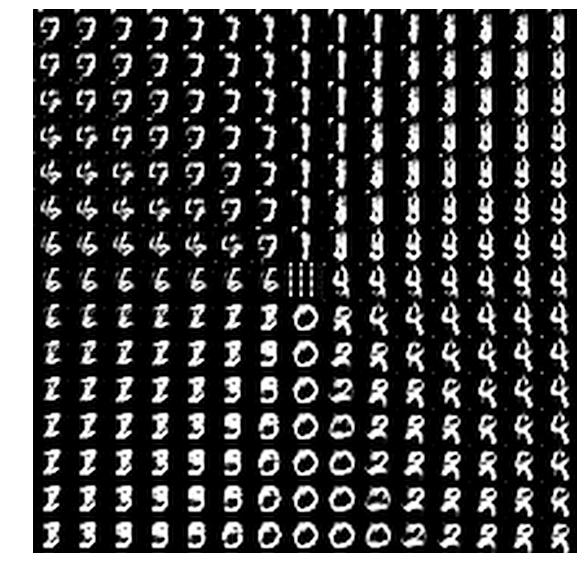

In [30]:
def draw_manifold_gan(model):
    generator = lambda z: model.generator(torch.from_numpy(z).float()).view(digit_size, digit_size).data.numpy()
    return draw_manifold(generator)

draw_manifold_gan(gan_model_d2['model'])

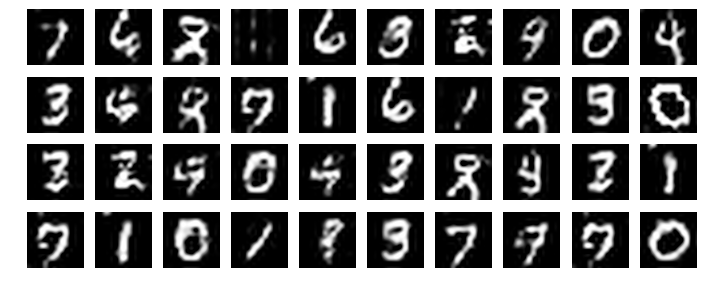

In [31]:
show_images(gan_model_d2['model'].generate_samples(40))

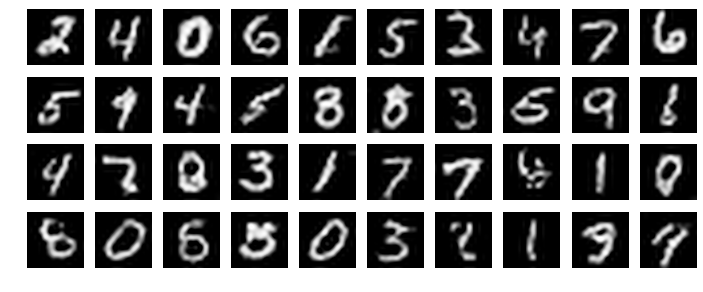

In [111]:
show_images(gan_model_d10['model'].generate_samples(40))

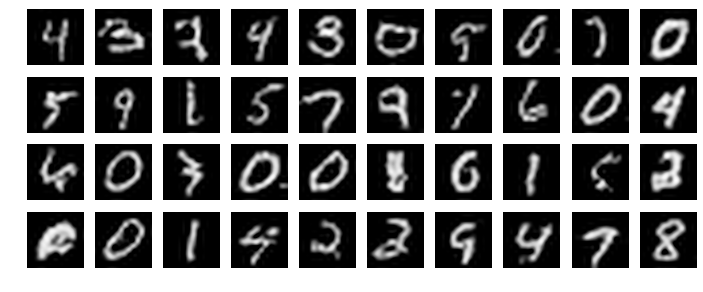

In [118]:
show_images(gan_model_d100['model'].generate_samples(40))

/home/nadya/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3116: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/home/nadya/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3122: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


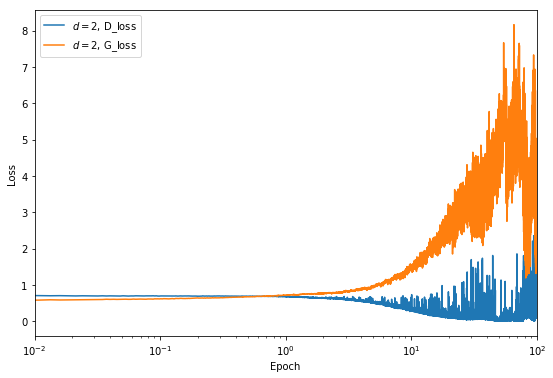

In [119]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 2$, D_loss', 'discriminator_losses', gan_model_d2),
    ('$d = 2$, G_loss', 'generator_losses', gan_model_d2),
]:
    data = model[name]
    x_labels = (1 + np.arange(len(data))) / len(data) * 100
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.01, xmax=x_labels[-1])
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
pass

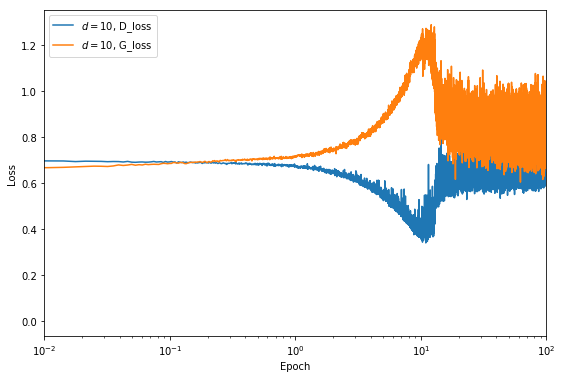

In [120]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 10$, D_loss', 'discriminator_losses', gan_model_d10),
    ('$d = 10$, G_loss', 'generator_losses', gan_model_d10),
]:
    data = model[name]
    x_labels = (1 + np.arange(len(data))) / len(data) * 100
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.01, xmax=x_labels[-1])
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
pass

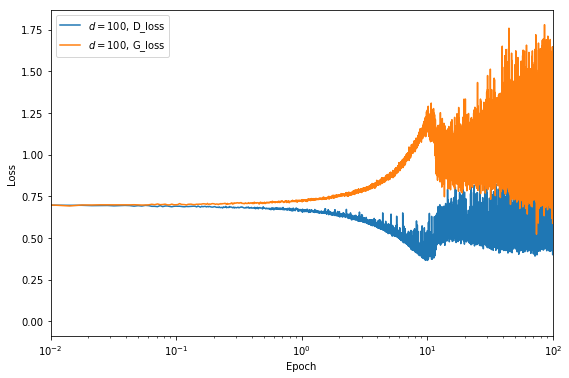

In [121]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 100$, D_loss', 'discriminator_losses', gan_model_d100),
    ('$d = 100$, G_loss', 'generator_losses', gan_model_d100),
]:
    data = model[name]
    x_labels = (1 + np.arange(len(data))) / len(data) * 100
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.01, xmax=x_labels[-1])
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
pass

In [34]:
generated_samples = generate_many_samples(gan_model_d2['model'], 8192, 64).detach()
%time log_likelihood(generated_samples, valid_data.tensors[0], test_data.tensors[0])

CPU times: user 3.46 s, sys: 960 ms, total: 4.42 s
Wall time: 1.11 s


-20.467525482177734

In [35]:
generated_samples = generate_many_samples(gan_model_d10['model'], 8192, 64).detach()
%time log_likelihood(generated_samples, valid_data.tensors[0], test_data.tensors[0])

CPU times: user 3.76 s, sys: 620 ms, total: 4.38 s
Wall time: 1.1 s


-19.440349578857422

In [36]:
generated_samples = generate_many_samples(gan_model_d100['model'], 8192, 64).detach()
%time log_likelihood(generated_samples, valid_data.tensors[0], test_data.tensors[0])

CPU times: user 3.75 s, sys: 600 ms, total: 4.35 s
Wall time: 1.09 s


-19.37473487854004

/home/nadya/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3116: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/home/nadya/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3122: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


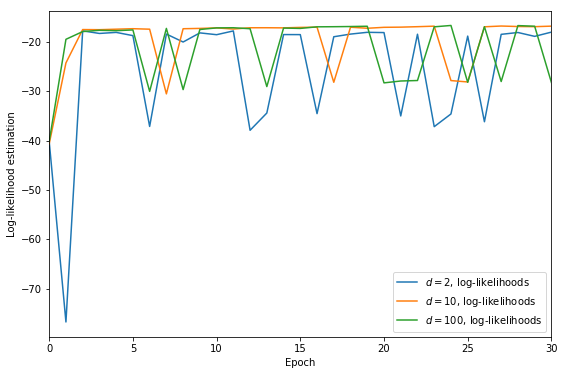

In [37]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 2$, log-likelihoods', 'log_likelihoods', gan_model_d2),
    ('$d = 10$, log-likelihoods', 'log_likelihoods', gan_model_d10),
    ('$d = 100$, log-likelihoods', 'log_likelihoods', gan_model_d100),
]:
    data = model[name]
    x_labels = np.arange(len(data))
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.0, xmax=x_labels[-1])
plt.ylabel('Log-likelihood estimation')
plt.legend()
pass

## Выводы
Место для ваших выводов, наблюдений, гипотез.